In [1]:
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMClassifier, Dataset, cv, train, early_stopping
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import __version__ as sklearn_version
from packaging import version
from multiprocessing import cpu_count
import numpy as np
import shap
import matplotlib.pyplot as plt
import polars as pl
import itertools
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model Development 

## Since Respiratory culture data is noisy you can remove it

In [2]:
df=pd.read_csv('Model1_AllABX_fixedTime0.csv')
df=df[df.culture_description!='RESPIRATORY'] # can be removed if you want to include respiratory cultures
df.head()

anon_id  pat_enc_csn_id_coded  order_proc_id_coded  \
0  JC2744063          131368600230            928257722   
1  JC2744063          131368600230            928257722   
2  JC2744063          131368600230            928257722   
3  JC2744063          131368600230            928257722   
4  JC2744063          131368600230            928257722   

     order_time_jittered_utc culture_description  year               organism  \
0  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   
1  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   
2  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   
3  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   
4  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   

   antibiotic implied_susceptibility  age  ...  prior_abx_class_Glycopeptide  \
0    Amikacin            Susceptible    7  ...                           0.0   
1    Cefepime            Susceptible    7  ...                           0.0   
2   Ertapenem            Susceptible    7  ...                           0.0   
3   Meropenem            Susceptible    7  ...                           0.0   
4  Ampicillin              Resistant    7  ...                           0.0   

   prior_abx_class_Macrolide Lincosamide  prior_abx_class_Monobactam  \
0                                    0.0                         0.0   
1                                    0.0                         0.0   
2                                    0.0                         0.0   
3                                    0.0                         0.0   
4                                    0.0                         0.0   

   prior_abx_class_Nitrofuran  prior_abx_class_Nitroimidazole  \
0                         0.0                             0.0   
1                         0.0                             0.0   
2                         0.0                             0.0   
3                         0.0                             0.0   
4                         0.0                             0.0   

   prior_abx_class_Oxazolidinone  prior_abx_class_Polymyxin, Lipopeptide  \
0                            0.0                                     0.0   
1                            0.0                                     0.0   
2                            0.0                                     0.0   
3                            0.0                                     0.0   
4                            0.0                                     0.0   

   prior_abx_class_Sulfonamide  prior_abx_class_Tetracycline  \
0                          0.0                           0.0   
1                          0.0                           0.0   
2                          0.0                           0.0   
3                          0.0                           0.0   
4                          0.0                           0.0   

   prior_abx_class_Urinary Antiseptic  
0                                 0.0  
1                                 0.0  
2                                 0.0  
3                                 0.0  
4                                 0.0  

[5 rows x 215 columns]

In [3]:
categorical_features=['antibiotic','implied_susceptibility','culture_description']
lab_features=['Q75_wbc','Q25_wbc', 'median_wbc', 'Q25_neutrophils', 'Q75_neutrophils',
       'median_neutrophils', 'Q25_lymphocytes', 'Q75_lymphocytes',
       'median_lymphocytes', 'Q25_hgb', 'Q75_hgb', 'median_hgb',
       'Q25_plt', 'Q75_plt', 'median_plt', 'Q75_na', 'Q25_na',
       'median_na', 'Q75_hco3', 'Q25_hco3', 'median_hco3', 'Q75_bun',
       'Q25_bun', 'median_bun', 'Q75_cr', 'Q25_cr','median_cr', 'Q75_lactate', 'Q25_lactate', 'median_lactate',
       'Q75_procalcitonin', 'Q25_procalcitonin', 'median_procalcitonin',
       'first_procalcitonin', 'last_procalcitonin', 'last_lactate',
       'first_lactate', 'last_cr', 'first_cr', 'last_bun', 'first_bun',
       'last_hco3', 'first_hco3', 'last_na', 'first_na', 'last_plt',
       'first_plt', 'last_hgb', 'first_hgb', 'last_lymphocytes',
       'first_lymphocytes', 'last_neutrophils', 'first_neutrophils',
       'last_wbc', 'first_wbc']
numeric_features=['age','gender','hosp_ward_IP', 'hosp_ward_OP', 'hosp_ward_ER',
       'hosp_ward_ICU', 'adi_score', 'Q25_heartrate', 'Q75_heartrate',
       'median_heartrate', 'Q25_resprate', 'Q75_resprate',
       'median_resprate', 'Q25_temp', 'Q75_temp', 'median_temp',
       'Q25_sysbp', 'Q75_sysbp', 'median_sysbp', 'Q25_diasbp',
       'Q75_diasbp','median_diasbp', 'first_diasbp', 'last_diasbp', 'last_sysbp',
       'first_sysbp', 'last_temp', 'first_temp', 'last_resprate',
       'first_resprate', 'last_heartrate', 'first_heartrate',
       'nursing_visits_within_6mo', 'urethral_catheter_within_6mo',
       'surgical_procedure_within_6mo', 'mechvent_within_6mo',
       'cvc_within_6mo', 'parenteral_nutrition_within_6mo',
       'dialysis_within_6mo', 
       'prior_med_Amikacin', 'prior_med_Ampicillin',
       'prior_med_Aztreonam', 'prior_med_Cefazolin', 'prior_med_Cefepime','prior_med_Cefoxitin', 'prior_med_Ceftazidime',
       'prior_med_Ceftriaxone', 'prior_med_Cipro',
       'prior_med_Ciprofloxacin', 'prior_med_Colistin',
       'prior_med_Ertapenem', 'prior_med_Gentamicin',
       'prior_med_Isoniazid', 'prior_med_Levaquin',
       'prior_med_Levofloxacin', 'prior_med_Linezolid',
       'prior_med_Metronidazole', 'prior_med_Penicillin',
       'prior_med_Vancomycin', 'prior_abx_class_Aminoglycoside',
       'prior_abx_class_Ansamycin', 'prior_abx_class_Antitubercular',
       'prior_abx_class_Beta Lactam',
       'prior_abx_class_Combination Antibiotic',
       'prior_abx_class_Fluoroquinolone',
       'prior_abx_class_Folate Synthesis Inhibitor',
       'prior_abx_class_Fosfomycin', 'prior_abx_class_Glycopeptide',
       'prior_abx_class_Macrolide Lincosamide',
       'prior_abx_class_Monobactam', 'prior_abx_class_Nitrofuran',
       'prior_abx_class_Nitroimidazole', 'prior_abx_class_Oxazolidinone',
       'prior_abx_class_Polymyxin, Lipopeptide','prior_abx_class_Sulfonamide', 'prior_abx_class_Tetracycline',
       'prior_abx_class_Urinary Antiseptic','prior_infected_Acinetobacter', 'prior_infected_CONS',
       'prior_infected_Candida', 'prior_infected_Citrobacter',
       'prior_infected_Enterobacter', 'prior_infected_Enterococcus',
       'prior_infected_Escherichia', 'prior_infected_Klebsiella',
       'prior_infected_Morganella', 'prior_infected_Proteus',
       'prior_infected_Providencia', 'prior_infected_Pseudomonas',
       'prior_infected_Serratia', 'prior_infected_Staphylococcus',
       'prior_infected_Stenotrophomonas', 'prior_infected_Streptococcus',
'ACHROMOBACTER XYLOSOXIDANS_Cefepime',
       'ACHROMOBACTER XYLOSOXIDANS_Ceftriaxone',
       'ACHROMOBACTER XYLOSOXIDANS_Ciprofloxacin',
       'ENTEROBACTER CLOACAE COMPLEX_Cefazolin',
       'ENTEROBACTER CLOACAE COMPLEX_Cefepime',
       'ENTEROBACTER CLOACAE COMPLEX_Ceftriaxone',
       'ENTEROBACTER CLOACAE COMPLEX_Ciprofloxacin',
       'ENTEROCOCCUS SPECIES_Ciprofloxacin', 'ESCHERICHIA COLI_Cefazolin',
       'ESCHERICHIA COLI_Cefepime', 'ESCHERICHIA COLI_Ceftriaxone',
       'ESCHERICHIA COLI_Ciprofloxacin',
       'KLEBSIELLA PNEUMONIAE_Cefazolin',
       'KLEBSIELLA PNEUMONIAE_Cefepime',
       'KLEBSIELLA PNEUMONIAE_Ceftriaxone',
       'KLEBSIELLA PNEUMONIAE_Ciprofloxacin',
       'MUCOID PSEUDOMONAS AERUGINOSA_Cefepime',
       'MUCOID PSEUDOMONAS AERUGINOSA_Ciprofloxacin',
       'PROTEUS MIRABILIS_Cefazolin', 'PROTEUS MIRABILIS_Cefepime',
       'PROTEUS MIRABILIS_Ceftriaxone','PROTEUS MIRABILIS_Ciprofloxacin',
       'PSEUDOMONAS AERUGINOSA (NON-MUCOID CF)_Cefepime',
       'PSEUDOMONAS AERUGINOSA (NON-MUCOID CF)_Ciprofloxacin',
       'PSEUDOMONAS AERUGINOSA_Cefazolin',
       'PSEUDOMONAS AERUGINOSA_Cefepime',
       'PSEUDOMONAS AERUGINOSA_Ciprofloxacin',
       'STAPHYLOCOCCUS AUREUS_Cefazolin',
       'STAPHYLOCOCCUS AUREUS_Ciprofloxacin'
                 ]

In [6]:
df[lab_features] = df[lab_features].apply(pd.to_numeric, errors = 'coerce')

In [7]:
for col in categorical_features:
    df[col]=df[col].astype('str')
    df.loc[df[col]=='Null',col]=None
    df[col] = df[col].astype('category')
df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors = 'coerce')
df['year'] = df['year'].astype(int)
df.head()

anon_id  pat_enc_csn_id_coded  order_proc_id_coded  \
0  JC2744063          131368600230            928257722   
1  JC2744063          131368600230            928257722   
2  JC2744063          131368600230            928257722   
3  JC2744063          131368600230            928257722   
4  JC2744063          131368600230            928257722   

     order_time_jittered_utc culture_description  year               organism  \
0  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   
1  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   
2  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   
3  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   
4  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   

   antibiotic implied_susceptibility  age  ...  prior_abx_class_Glycopeptide  \
0    Amikacin            Susceptible    7  ...                           0.0   
1    Cefepime            Susceptible    7  ...                           0.0   
2   Ertapenem            Susceptible    7  ...                           0.0   
3   Meropenem            Susceptible    7  ...                           0.0   
4  Ampicillin              Resistant    7  ...                           0.0   

   prior_abx_class_Macrolide Lincosamide  prior_abx_class_Monobactam  \
0                                    0.0                         0.0   
1                                    0.0                         0.0   
2                                    0.0                         0.0   
3                                    0.0                         0.0   
4                                    0.0                         0.0   

   prior_abx_class_Nitrofuran  prior_abx_class_Nitroimidazole  \
0                         0.0                             0.0   
1                         0.0                             0.0   
2                         0.0                             0.0   
3                         0.0                             0.0   
4                         0.0                             0.0   

   prior_abx_class_Oxazolidinone  prior_abx_class_Polymyxin, Lipopeptide  \
0                            0.0                                     0.0   
1                            0.0                                     0.0   
2                            0.0                                     0.0   
3                            0.0                                     0.0   
4                            0.0                                     0.0   

   prior_abx_class_Sulfonamide  prior_abx_class_Tetracycline  \
0                          0.0                           0.0   
1                          0.0                           0.0   
2                          0.0                           0.0   
3                          0.0                           0.0   
4                          0.0                           0.0   

   prior_abx_class_Urinary Antiseptic  
0                                 0.0  
1                                 0.0  
2                                 0.0  
3                                 0.0  
4                                 0.0  

[5 rows x 215 columns]

## Add  identifier columns for each culture record

In [8]:
df["case_id"] = df.groupby(["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded"]).ngroup()
df.head()

/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_51772/2640269478.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["case_id"] = df.groupby(["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded"]).ngroup()


anon_id  pat_enc_csn_id_coded  order_proc_id_coded  \
0  JC2744063          131368600230            928257722   
1  JC2744063          131368600230            928257722   
2  JC2744063          131368600230            928257722   
3  JC2744063          131368600230            928257722   
4  JC2744063          131368600230            928257722   

     order_time_jittered_utc culture_description  year               organism  \
0  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   
1  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   
2  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   
3  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   
4  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   

   antibiotic implied_susceptibility  age  ...  \
0    Amikacin            Susceptible    7  ...   
1    Cefepime            Susceptible    7  ...   
2   Ertapenem            Susceptible    7  ...   
3   Meropenem            Susceptible    7  ...   
4  Ampicillin              Resistant    7  ...   

   prior_abx_class_Macrolide Lincosamide  prior_abx_class_Monobactam  \
0                                    0.0                         0.0   
1                                    0.0                         0.0   
2                                    0.0                         0.0   
3                                    0.0                         0.0   
4                                    0.0                         0.0   

   prior_abx_class_Nitrofuran  prior_abx_class_Nitroimidazole  \
0                         0.0                             0.0   
1                         0.0                             0.0   
2                         0.0                             0.0   
3                         0.0                             0.0   
4                         0.0                             0.0   

   prior_abx_class_Oxazolidinone  prior_abx_class_Polymyxin, Lipopeptide  \
0                            0.0                                     0.0   
1                            0.0                                     0.0   
2                            0.0                                     0.0   
3                            0.0                                     0.0   
4                            0.0                                     0.0   

   prior_abx_class_Sulfonamide  prior_abx_class_Tetracycline  \
0                          0.0                           0.0   
1                          0.0                           0.0   
2                          0.0                           0.0   
3                          0.0                           0.0   
4                          0.0                           0.0   

   prior_abx_class_Urinary Antiseptic  case_id  
0                                 0.0    30255  
1                                 0.0    30255  
2                                 0.0    30255  
3                                 0.0    30255  
4                                 0.0    30255  

[5 rows x 216 columns]

## Keep only antibiotics with 1000 or more records for the antibiotic being modeled, and those with resistance prevelance between 5% and 95%
### For more accurate model you can filter out low prevelance organism as well. 

In [9]:
ABXs=df.antibiotic.unique()
Relevant_ABX=[]
for abx in ABXs:
   if df[(df.antibiotic==abx)].case_id.nunique()>1000:
        prev=df[(df.antibiotic==abx)&(df.implied_susceptibility=='Resistant')].case_id.nunique()/df[(df.antibiotic==abx)].case_id.nunique()*100
        if prev>5 and prev<95:
            Relevant_ABX.append(abx)

In [ ]:
np.save('Relevant_ABX_inpatient',Relevant_ABX)

In [10]:
# select only antibtics with at least ~10% prevelence 
df=df[df.antibiotic.isin(Relevant_ABX)]

## fix the name of the antibiotic

In [11]:
df.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)
df.rename(columns=lambda x: x.replace(",_", "_"), inplace=True)

/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_51772/279142439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)
/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_51772/279142439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=lambda x: x.replace(",_", "_"), inplace=True)


### add Identifiers_id for each record

In [12]:
identifiers=df[['anon_id','pat_enc_csn_id_coded','order_proc_id_coded','order_time_jittered_utc']]
identifiers.drop_duplicates(inplace=True)
identifiers_filtered=identifiers.loc[identifiers.groupby(["anon_id", "pat_enc_csn_id_coded"])["order_time_jittered_utc"].idxmin()]
identifiers_filtered = identifiers_filtered.reset_index(drop=True)
identifiers_filtered

/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_51772/22729834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identifiers.drop_duplicates(inplace=True)


anon_id  pat_enc_csn_id_coded  order_proc_id_coded  \
0      JC1000055          131007208496            358503237   
1      JC1000080          131022310457            412620150   
2      JC1000083          131008798135            364762539   
3      JC1000083          131012436076            379081590   
4      JC1000083          131013906068            384652929   
...          ...                   ...                  ...   
57025   JC999374          131024874435            420600992   
57026   JC999499              16008739            328001821   
57027   JC999590          131022787414            414242433   
57028   JC999695          131240032823            539891925   
57029   JC999814          131030666251            437175086   

         order_time_jittered_utc  
0      2009-10-15 03:25:00+00:00  
1      2013-01-28 02:41:00+00:00  
2      2010-03-29 21:10:00+00:00  
3      2011-02-18 22:25:00+00:00  
4      2011-06-18 00:10:00+00:00  
...                          ...  
57025  2013-05-31 15:31:00+00:00  
57026  2008-06-08 05:57:00+00:00  
57027  2013-02-03 23:32:00+00:00  
57028  2017-10-05 20:26:00+00:00  
57029  2014-04-18 00:48:00+00:00  

[57030 rows x 4 columns]

In [ ]:
df_index_orders=df.merge(identifiers_filtered,how='inner',on=['anon_id','pat_enc_csn_id_coded','order_proc_id_coded','order_time_jittered_utc'])
df=[]
df_index_orders.shape

In [ ]:
df_index_orders.to_csv('DF_index_orders_InPatients.csv',index=False)


## if you have memory issues you can read and process in chunks like cell below

In [ ]:

chunk_size = 10000  # Adjust based on your system's memory

# Initialize an empty list to store processed chunks
chunks = []

# Read CSV file in chunks
for chunk in pd.read_csv("DF_index_orders_InPatients.csv", chunksize=chunk_size):
    chunks.append(chunk)

# Combine all chunks into a single DataFrame
df_index_orders = pd.concat(chunks, ignore_index=True)

# Display the first few rows
print(df_index_orders.head())

     anon_id  pat_enc_csn_id_coded  order_proc_id_coded  \
0  JC2744063          131368600230            928257722   
1  JC2744063          131368600230            928257722   
2  JC2744063          131368600230            928257722   
3  JC2744063          131368600230            928257722   
4  JC2744063          131368600230            928257722   

   order_time_jittered_utc_x culture_description  year               organism  \
0  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   
1  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   
2  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   
3  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   
4  2023-12-23 22:29:00+00:00               URINE  2023  KLEBSIELLA PNEUMONIAE   

    antibiotic implied_susceptibility  age  ...  first_plt  last_hgb  \
0     Cefepime            Susceptible    7  ...        NaN       NaN   
1   Ampicillin

In [6]:
categorical_features=['antibiotic','implied_susceptibility','culture_description']
lab_features=['Q75_wbc','Q25_wbc', 'median_wbc', 'Q25_neutrophils', 'Q75_neutrophils',
       'median_neutrophils', 'Q25_lymphocytes', 'Q75_lymphocytes',
       'median_lymphocytes', 'Q25_hgb', 'Q75_hgb', 'median_hgb',
       'Q25_plt', 'Q75_plt', 'median_plt', 'Q75_na', 'Q25_na',
       'median_na', 'Q75_hco3', 'Q25_hco3', 'median_hco3', 'Q75_bun',
       'Q25_bun', 'median_bun', 'Q75_cr', 'Q25_cr','median_cr', 'Q75_lactate', 'Q25_lactate', 'median_lactate',
       'Q75_procalcitonin', 'Q25_procalcitonin', 'median_procalcitonin',
       'first_procalcitonin', 'last_procalcitonin', 'last_lactate',
       'first_lactate', 'last_cr', 'first_cr', 'last_bun', 'first_bun',
       'last_hco3', 'first_hco3', 'last_na', 'first_na', 'last_plt',
       'first_plt', 'last_hgb', 'first_hgb', 'last_lymphocytes',
       'first_lymphocytes', 'last_neutrophils', 'first_neutrophils',
       'last_wbc', 'first_wbc']
numeric_features=['age','gender','hosp_ward_IP', 'hosp_ward_OP', 'hosp_ward_ER',
       'hosp_ward_ICU', 'adi_score', 'Q25_heartrate', 'Q75_heartrate',
       'median_heartrate', 'Q25_resprate', 'Q75_resprate',
       'median_resprate', 'Q25_temp', 'Q75_temp', 'median_temp',
       'Q25_sysbp', 'Q75_sysbp', 'median_sysbp', 'Q25_diasbp',
       'Q75_diasbp','median_diasbp', 'first_diasbp', 'last_diasbp', 'last_sysbp',
       'first_sysbp', 'last_temp', 'first_temp', 'last_resprate',
       'first_resprate', 'last_heartrate', 'first_heartrate',
       'nursing_visits_within_6mo', 'urethral_catheter_within_6mo',
       'surgical_procedure_within_6mo', 'mechvent_within_6mo',
       'cvc_within_6mo', 'parenteral_nutrition_within_6mo',
       'dialysis_within_6mo', 
       'prior_med_Amikacin', 'prior_med_Ampicillin',
       'prior_med_Aztreonam', 'prior_med_Cefazolin', 'prior_med_Cefepime','prior_med_Cefoxitin', 'prior_med_Ceftazidime',
       'prior_med_Ceftriaxone', 'prior_med_Cipro',
       'prior_med_Ciprofloxacin', 'prior_med_Colistin',
       'prior_med_Ertapenem', 'prior_med_Gentamicin',
       'prior_med_Isoniazid', 'prior_med_Levaquin',
       'prior_med_Levofloxacin', 'prior_med_Linezolid',
       'prior_med_Metronidazole', 'prior_med_Penicillin',
       'prior_med_Vancomycin', 'prior_abx_class_Aminoglycoside',
       'prior_abx_class_Ansamycin', 'prior_abx_class_Antitubercular',
       'prior_abx_class_Fluoroquinolone',
       'prior_abx_class_Fosfomycin', 'prior_abx_class_Glycopeptide',
       'prior_abx_class_Monobactam', 'prior_abx_class_Nitrofuran',
       'prior_abx_class_Nitroimidazole', 'prior_abx_class_Oxazolidinone',
       'prior_abx_class_Sulfonamide', 'prior_abx_class_Tetracycline',
       'prior_infected_Acinetobacter', 'prior_infected_CONS',
       'prior_infected_Candida', 'prior_infected_Citrobacter',
       'prior_infected_Enterobacter', 'prior_infected_Enterococcus',
       'prior_infected_Escherichia', 'prior_infected_Klebsiella',
       'prior_infected_Morganella', 'prior_infected_Proteus',
       'prior_infected_Providencia', 'prior_infected_Pseudomonas',
       'prior_infected_Serratia', 'prior_infected_Staphylococcus',
       'prior_infected_Stenotrophomonas', 'prior_infected_Streptococcus',
]

In [ ]:
for col in categorical_features:
    df_index_orders[col]=df_index_orders[col].astype('str')
    df_index_orders.loc[df_index_orders[col]=='Null',col]=None
    df_index_orders[col] = df_index_orders[col].astype('category')
df_index_orders[numeric_features] = df_index_orders[numeric_features].apply(pd.to_numeric, errors = 'coerce')
df_index_orders['year'] = df_index_orders['year'].astype(int)
df_index_orders.head()

## keep only antibiotics with 1000 or more records for the antibiotic being modeled, and those with resistance prevelance between 5% and 95%
### For more accurate model you can filter out low prevelance organism as well.

In [ ]:
ABXs=df_index_orders.antibiotic.unique()
Relevant_ABX=[]
for abx in ABXs:
    if df_index_orders[(df_index_orders.antibiotic==abx)].case_id.nunique()>1000:
        prev=df_index_orders[(df_index_orders.antibiotic==abx)&(df_index_orders.implied_susceptibility=='Resistant')].case_id.nunique()/df_index_orders[(df_index_orders.antibiotic==abx)].case_id.nunique()*100
        if prev>5 and prev<95: 
            Relevant_ABX.append(abx)
            

## Model Training and Evalution

### Here we compared light GBM classifer with Xgboost but we found Xgboost either works similar to light GBM or slightly works better 

In [ ]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress warnings


### Model training with XGBoost
def train_test_xgb(df, model_antibiotic, features):
    df = df[features + ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'implied_susceptibility', 'year', 'culture_description']]
    df = (
        df[df['antibiotic'] == model_antibiotic]
        .drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'])
        .reset_index(drop=True)
    )
    
    label_enc = LabelEncoder()
    df['implied_susceptibility'] = label_enc.fit_transform(df['implied_susceptibility'])
    # either d label mapping or use your own mapping for binary classification
    label_mapping = dict(zip(label_enc.classes_, label_enc.transform(label_enc.classes_)))
    print(label_mapping)
    print('*****************************')
    
    # split data into train, val, test chronologically
    df_train = df[df.year < 2020].drop(columns=['year'])
    df_val = df[df['year'].isin([2020, 2021])].drop(columns=['year'])
    df_test = df[df['year'] >= 2022].drop(columns=['year'])
    
    # Categorical features are encoded consistently across splits
    for col in ['antibiotic', 'culture_description']:
        encoder = LabelEncoder()
        encoder.fit(df_train[col])
        df_val = df_val[df_val[col].isin(encoder.classes_)]
        df_test = df_test[df_test[col].isin(encoder.classes_)]
        
        df_train[col] = encoder.transform(df_train[col])
        df_val[col] = encoder.transform(df_val[col])
        df_test[col] = encoder.transform(df_test[col])
    
    X_train, y_train = df_train[features], df_train['implied_susceptibility']
    X_val, y_val = df_val[features], df_val['implied_susceptibility']
    X_test, y_test = df_test[features], df_test['implied_susceptibility']
   
    
    if set(X_train.columns) != set(X_test.columns):
        raise ValueError("Feature names in train and test sets do not match")
    
    # use RFE to select best set of features based on validation set
    selected_features = tune_rfe(X_val, y_val)
    X_train, X_val, X_test = X_train[selected_features], X_val[selected_features], X_test[selected_features]

    # Hyperparameter tuning using RandomizedSearchCV and 5 fold CV
    best_params = tune_xgb(X_train, y_train)
    best_params.update({"eval_metric": "auc"})

    
    model = XGBClassifier(**best_params, use_label_encoder=False,early_stopping_rounds=30, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    predictions = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, predictions)
    fpr, tpr, _ = roc_curve(y_test, predictions)
    predicted_classes = (predictions >= 0.5).astype(int)
    cm = confusion_matrix(y_test, predicted_classes)
    
    train_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, predictions)
    
    if train_auc - test_auc > 0.1:
        print("Warning: Possible overfitting detected")
    
    return {
        'antibiotic': model_antibiotic.title(),
        'model': model,
        'selected_features': selected_features,
        'best_tune': best_params,
        'df_train': df_train,
        'df_test': df_test,
        'predictions': predictions,
        'auc': auc,
        'roc': {'fpr': fpr, 'tpr': tpr},
        'cm': cm
    }

### RFE Feature selection
def tune_rfe(X, y):
    
    feature_counts = [30, 50, 70, 90, len(X.columns)]
    best_auc = np.NINF
    best_n_features = 30
    best_features=[]
    for n_features in feature_counts:
        model = XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42)
        rfe = RFE(estimator=model, n_features_to_select=n_features, step=1)
        rfe.fit(X, y)

        # Use `.loc` to select features correctly
        X_selected = X.loc[:, rfe.support_]
        auc = cross_val_auc(X_selected, y)  # Ensure this function is defined

        if auc > best_auc:
            best_auc = auc
            best_n_features = n_features
            best_features=X.columns[rfe.support_]
    return best_features

### Hyperparameter Tuning for XGBoost
def tune_xgb(X, y):
    param_distributions = {
        'learning_rate': uniform(0.001, 0.1),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'lambda': uniform(0, 100),
        'alpha': uniform(0, 100),
        'max_depth': randint(3, 12),
        'n_estimators': randint(50, 100),
    }
    
    model = XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False, random_state=42)
    
    search = RandomizedSearchCV(model, param_distributions, n_iter=30, scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)
    search.fit(X, y)
    return search.best_params_

### Cross-validation AUC Score
def cross_val_auc(X, y):
    model = XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='auc', random_state=42)
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    return np.mean(scores)


In [ ]:
categorical_features=['antibiotic','implied_susceptibility','culture_description']
lab_features=['Q75_wbc','Q25_wbc', 'median_wbc', 'Q25_neutrophils', 'Q75_neutrophils',
       'median_neutrophils', 'Q25_lymphocytes', 'Q75_lymphocytes',
       'median_lymphocytes', 'Q25_hgb', 'Q75_hgb', 'median_hgb',
       'Q25_plt', 'Q75_plt', 'median_plt', 'Q75_na', 'Q25_na',
       'median_na', 'Q75_hco3', 'Q25_hco3', 'median_hco3', 'Q75_bun',
       'Q25_bun', 'median_bun', 'Q75_cr', 'Q25_cr','median_cr', 'Q75_lactate', 'Q25_lactate', 'median_lactate',
       'Q75_procalcitonin', 'Q25_procalcitonin', 'median_procalcitonin',
       'first_procalcitonin', 'last_procalcitonin', 'last_lactate',
       'first_lactate', 'last_cr', 'first_cr', 'last_bun', 'first_bun',
       'last_hco3', 'first_hco3', 'last_na', 'first_na', 'last_plt',
       'first_plt', 'last_hgb', 'first_hgb', 'last_lymphocytes',
       'first_lymphocytes', 'last_neutrophils', 'first_neutrophils',
       'last_wbc', 'first_wbc']
numeric_features=['age','gender','hosp_ward_IP', 'hosp_ward_OP', 'hosp_ward_ER',
       'hosp_ward_ICU', 'adi_score', 'Q25_heartrate', 'Q75_heartrate',
       'median_heartrate', 'Q25_resprate', 'Q75_resprate',
       'median_resprate', 'Q25_temp', 'Q75_temp', 'median_temp',
       'Q25_sysbp', 'Q75_sysbp', 'median_sysbp', 'Q25_diasbp',
       'Q75_diasbp','median_diasbp', 'first_diasbp', 'last_diasbp', 'last_sysbp',
       'first_sysbp', 'last_temp', 'first_temp', 'last_resprate',
       'first_resprate', 'last_heartrate', 'first_heartrate',
       'nursing_visits_within_6mo', 'urethral_catheter_within_6mo',
       'surgical_procedure_within_6mo', 'mechvent_within_6mo',
       'cvc_within_6mo', 'parenteral_nutrition_within_6mo',
       'dialysis_within_6mo', 
       'prior_med_Amikacin', 'prior_med_Ampicillin',
       'prior_med_Aztreonam', 'prior_med_Cefazolin', 'prior_med_Cefepime','prior_med_Cefoxitin', 'prior_med_Ceftazidime',
       'prior_med_Ceftriaxone', 'prior_med_Cipro',
       'prior_med_Ciprofloxacin', 'prior_med_Colistin',
       'prior_med_Ertapenem', 'prior_med_Gentamicin',
       'prior_med_Isoniazid', 'prior_med_Levaquin',
       'prior_med_Levofloxacin', 'prior_med_Linezolid',
       'prior_med_Metronidazole', 'prior_med_Penicillin',
       'prior_med_Vancomycin', 'prior_abx_class_Aminoglycoside',
       'prior_abx_class_Ansamycin', 'prior_abx_class_Antitubercular',
       'prior_abx_class_Beta Lactam',
       'prior_abx_class_Combination Antibiotic',
       'prior_abx_class_Fluoroquinolone',
       'prior_abx_class_Folate Synthesis Inhibitor',
       'prior_abx_class_Fosfomycin', 'prior_abx_class_Glycopeptide',
       'prior_abx_class_Macrolide Lincosamide',
       'prior_abx_class_Monobactam', 'prior_abx_class_Nitrofuran',
       'prior_abx_class_Nitroimidazole', 'prior_abx_class_Oxazolidinone',
       'prior_abx_class_Polymyxin, Lipopeptide','prior_abx_class_Sulfonamide', 'prior_abx_class_Tetracycline',
       'prior_abx_class_Urinary Antiseptic','prior_infected_Acinetobacter', 'prior_infected_CONS',
       'prior_infected_Candida', 'prior_infected_Citrobacter',
       'prior_infected_Enterobacter', 'prior_infected_Enterococcus',
       'prior_infected_Escherichia', 'prior_infected_Klebsiella',
       'prior_infected_Morganella', 'prior_infected_Proteus',
       'prior_infected_Providencia', 'prior_infected_Pseudomonas',
       'prior_infected_Serratia', 'prior_infected_Staphylococcus',
       'prior_infected_Stenotrophomonas', 'prior_infected_Streptococcus']
# for either including or excluding historical antimicrobial resistance
"""
'ACHROMOBACTER XYLOSOXIDANS_Cefazolin',
       'ACHROMOBACTER XYLOSOXIDANS_Cefepime',
       'ACHROMOBACTER XYLOSOXIDANS_Ceftriaxone',
       'ACHROMOBACTER XYLOSOXIDANS_Ciprofloxacin',
       'ENTEROBACTER CLOACAE COMPLEX_Cefazolin',
       'ENTEROBACTER CLOACAE COMPLEX_Cefepime',
       'ENTEROBACTER CLOACAE COMPLEX_Ceftriaxone',
       'ENTEROBACTER CLOACAE COMPLEX_Ciprofloxacin',
       'ENTEROCOCCUS SPECIES_Ciprofloxacin', 'ESCHERICHIA COLI_Cefazolin',
       'ESCHERICHIA COLI_Cefepime', 'ESCHERICHIA COLI_Ceftriaxone',
       'ESCHERICHIA COLI_Ciprofloxacin',
       'KLEBSIELLA PNEUMONIAE_Cefazolin',
       'KLEBSIELLA PNEUMONIAE_Cefepime',
       'KLEBSIELLA PNEUMONIAE_Ceftriaxone',
       'KLEBSIELLA PNEUMONIAE_Ciprofloxacin',
       'MUCOID PSEUDOMONAS AERUGINOSA_Cefepime',
       'MUCOID PSEUDOMONAS AERUGINOSA_Ciprofloxacin',
       'PROTEUS MIRABILIS_Cefazolin', 'PROTEUS MIRABILIS_Cefepime',
       'PROTEUS MIRABILIS_Ceftriaxone','PROTEUS MIRABILIS_Ciprofloxacin',
       'PSEUDOMONAS AERUGINOSA (NON-MUCOID CF)_Cefepime',
       'PSEUDOMONAS AERUGINOSA (NON-MUCOID CF)_Ciprofloxacin',
       'PSEUDOMONAS AERUGINOSA_Cefazolin',
       'PSEUDOMONAS AERUGINOSA_Cefepime',
       'PSEUDOMONAS AERUGINOSA_Ceftriaxone',
       'PSEUDOMONAS AERUGINOSA_Ciprofloxacin',
       'STAPHYLOCOCCUS AUREUS_Cefazolin',
       'STAPHYLOCOCCUS AUREUS_Ciprofloxacin']
"""

"\n\n'ACHROMOBACTER XYLOSOXIDANS_Cefazolin',\n       'ACHROMOBACTER XYLOSOXIDANS_Cefepime',\n       'ACHROMOBACTER XYLOSOXIDANS_Ceftriaxone',\n       'ACHROMOBACTER XYLOSOXIDANS_Ciprofloxacin',\n       'ENTEROBACTER CLOACAE COMPLEX_Cefazolin',\n       'ENTEROBACTER CLOACAE COMPLEX_Cefepime',\n       'ENTEROBACTER CLOACAE COMPLEX_Ceftriaxone',\n       'ENTEROBACTER CLOACAE COMPLEX_Ciprofloxacin',\n       'ENTEROCOCCUS SPECIES_Ciprofloxacin', 'ESCHERICHIA COLI_Cefazolin',\n       'ESCHERICHIA COLI_Cefepime', 'ESCHERICHIA COLI_Ceftriaxone',\n       'ESCHERICHIA COLI_Ciprofloxacin',\n       'KLEBSIELLA PNEUMONIAE_Cefazolin',\n       'KLEBSIELLA PNEUMONIAE_Cefepime',\n       'KLEBSIELLA PNEUMONIAE_Ceftriaxone',\n       'KLEBSIELLA PNEUMONIAE_Ciprofloxacin',\n       'MUCOID PSEUDOMONAS AERUGINOSA_Cefepime',\n       'MUCOID PSEUDOMONAS AERUGINOSA_Ciprofloxacin',\n       'PROTEUS MIRABILIS_Cefazolin', 'PROTEUS MIRABILIS_Cefepime',\n       'PROTEUS MIRABILIS_Ceftriaxone','PROTEUS MIRABILIS_Cipr

In [ ]:
# adjust features for modeling based on whether historical resistance, labs, vitals, etc  is included or not,
model_features = ['antibiotic'] + numeric_features + lab_features
model_features = [feature.replace(" ", "_") for feature in model_features]
model_features = [feature.replace(",_", "_") for feature in model_features]

In [ ]:
Sotre_Models_microbial={}
Sotre_Models={}

In [ ]:
for abx in Relevant_ABX:
    if df_index_orders[df_index_orders.antibiotic==abx].implied_susceptibility.nunique()>1:
        model_abx = train_test_xgb(df_index_orders,abx, model_features)
        Sotre_Models[abx]=model_abx
        

Cefepime
Cefepime
{'Resistant': 0, 'Susceptible': 1}
*****************************
data splits completed 
X train and test and val is generated


/Users/fa/Documents/GCP_env/env_gcp/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:55:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/fa/Documents/GCP_env/env_gcp/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:55:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/fa/Documents/GCP_env/env_gcp/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:55:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/fa/Documents/GCP_env/env_gcp/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:55:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are no

tune xgb for best params is done {'alpha': 5.8652234443133615, 'colsample_bytree': 0.8563166894032441, 'lambda': 3.1068641929163254, 'learning_rate': 0.04531308926805101, 'max_depth': 6, 'n_estimators': 98, 'subsample': 0.5781331828027206, 'eval_metric': 'auc'}
**************************************


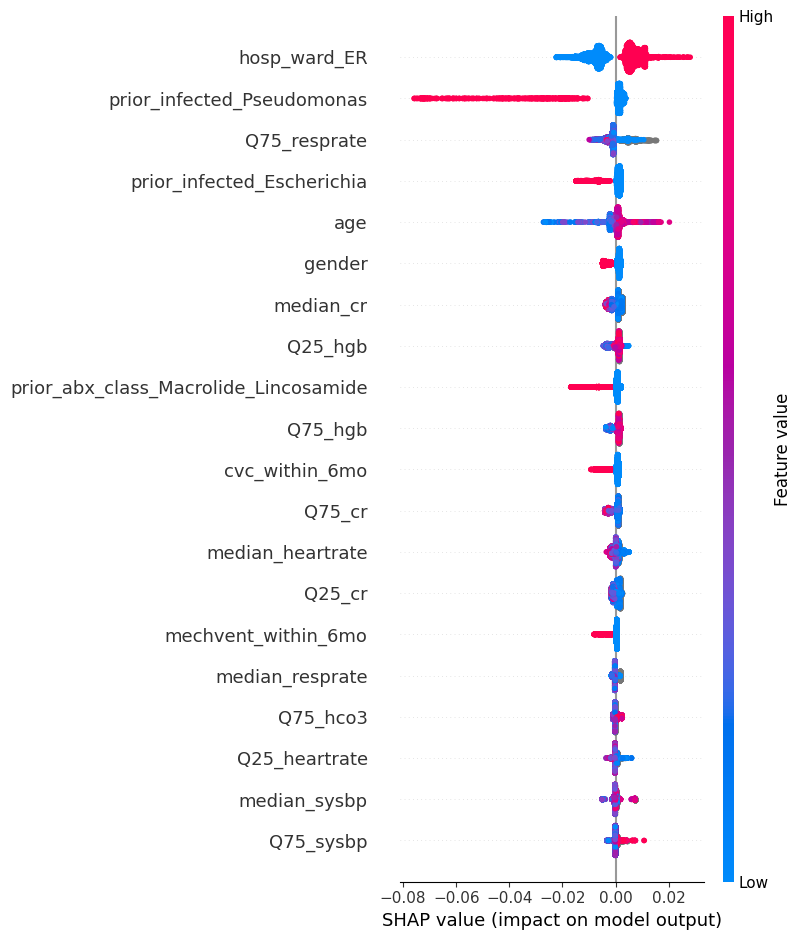

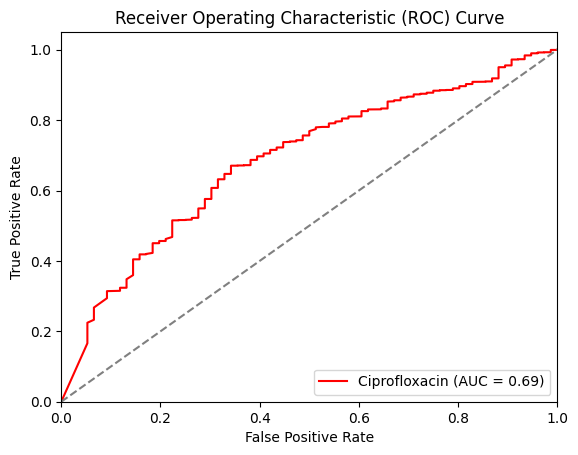

In [ ]:
def plot_shap_importance(model):
    features = model['selected_features']
    model['df_train'].columns = model['df_train'].columns.str.replace(' ', '_')
    model['df_test'].columns = model['df_test'].columns.str.replace(' ', '_')

    X_train = model['df_train'][features]
    X_test = model['df_test'][features]

    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)

    X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

    explainer = shap.Explainer(model['model'])

    shap_values = explainer.shap_values(X_train)

    shap.summary_plot(shap_values, X_train)


plot_shap_importance(model_ciprofloxacin)

### plot model metrics
fpr1, tpr1 = model_ciprofloxacin['roc']['fpr'], model_ciprofloxacin['roc']['tpr']

roc_auc1 = auc(fpr1, tpr1)

plt.figure()

# plot ciprofloxacin model
plt.plot(fpr1, tpr1, color='red', label=f'Ciprofloxacin (AUC = {roc_auc1:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
